Inspired by https://f1metrics.wordpress.com/2014/10/03/building-a-race-simulator/



In [1]:
import fastf1 as ff1
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from race import *
from constants import *
from practice import *
from scipy import stats

# Enable the cache by providing the name of the cache folder
ff1.Cache.enable_cache('cache')

In [2]:
DRIVER = 'VER'

#### FP2

In [3]:
FP2 = ff1.get_session(2022, 'Hungary', 'FP2')
FP2.load();

core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v2.2.9]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '47', '44', '31', '24', '23', '22', '20', '18', '16', '14', '11', '10', '6', '5', '4', '3', '63', '77']


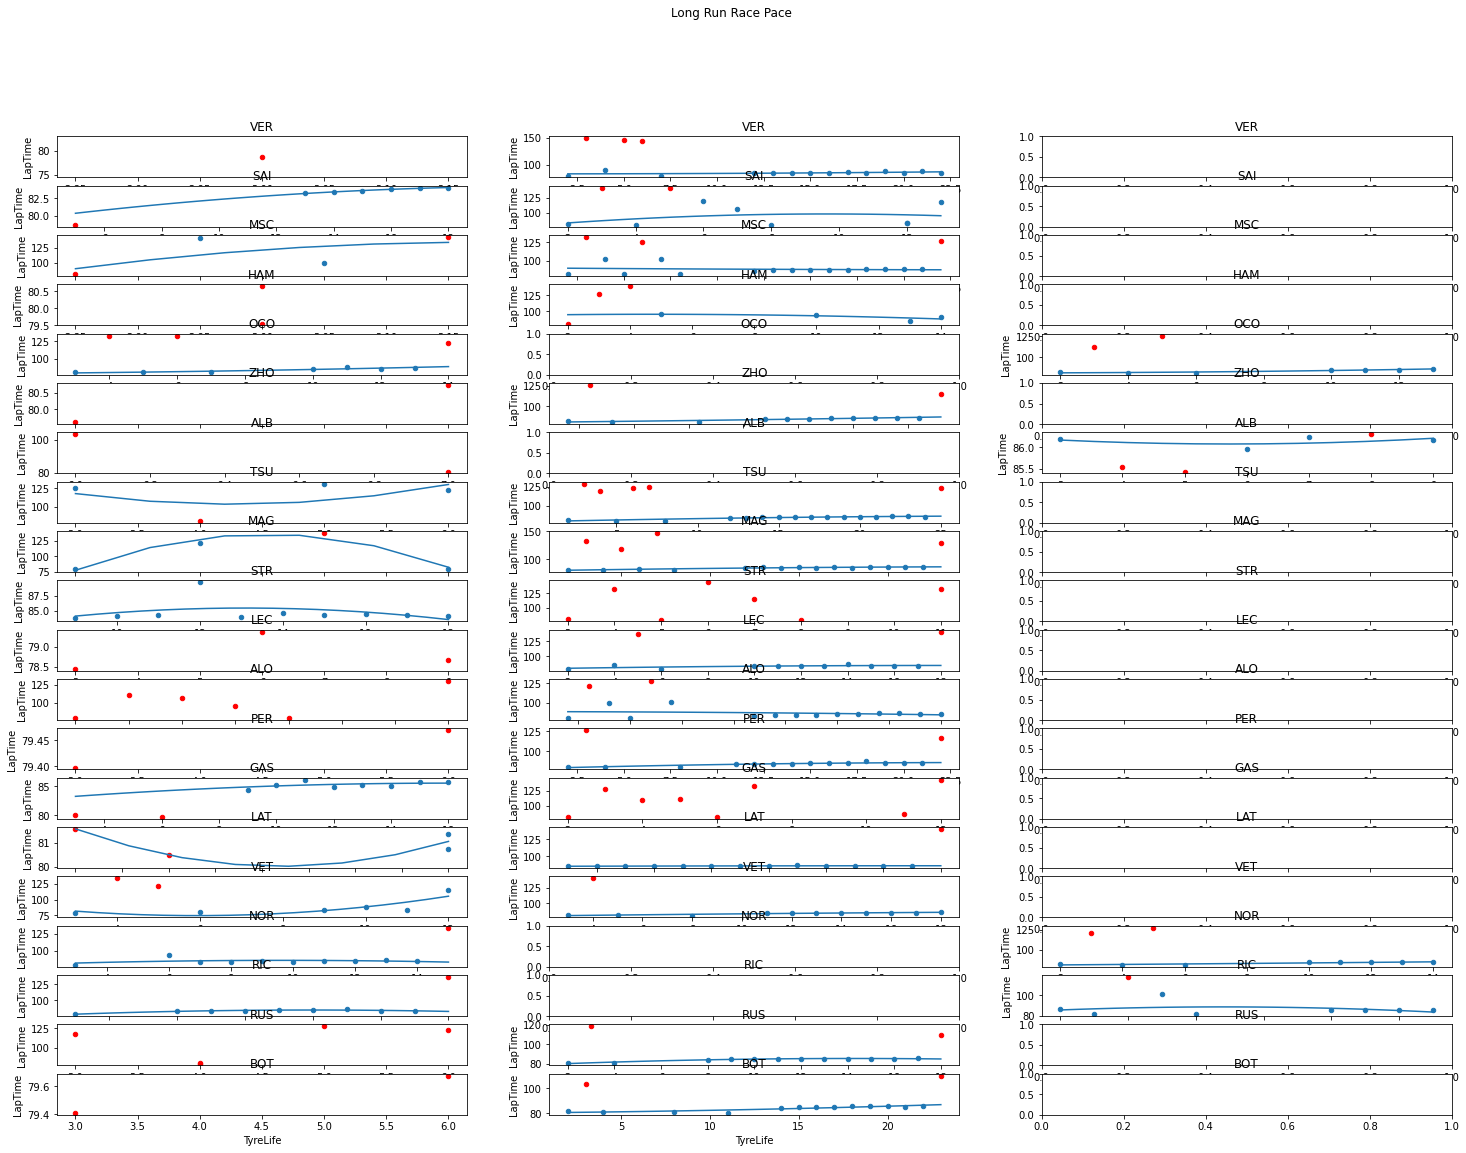

In [4]:
plot_dry_tyre_models_all_drivers(FP2.laps, get_all_driver_names(FP2.laps))

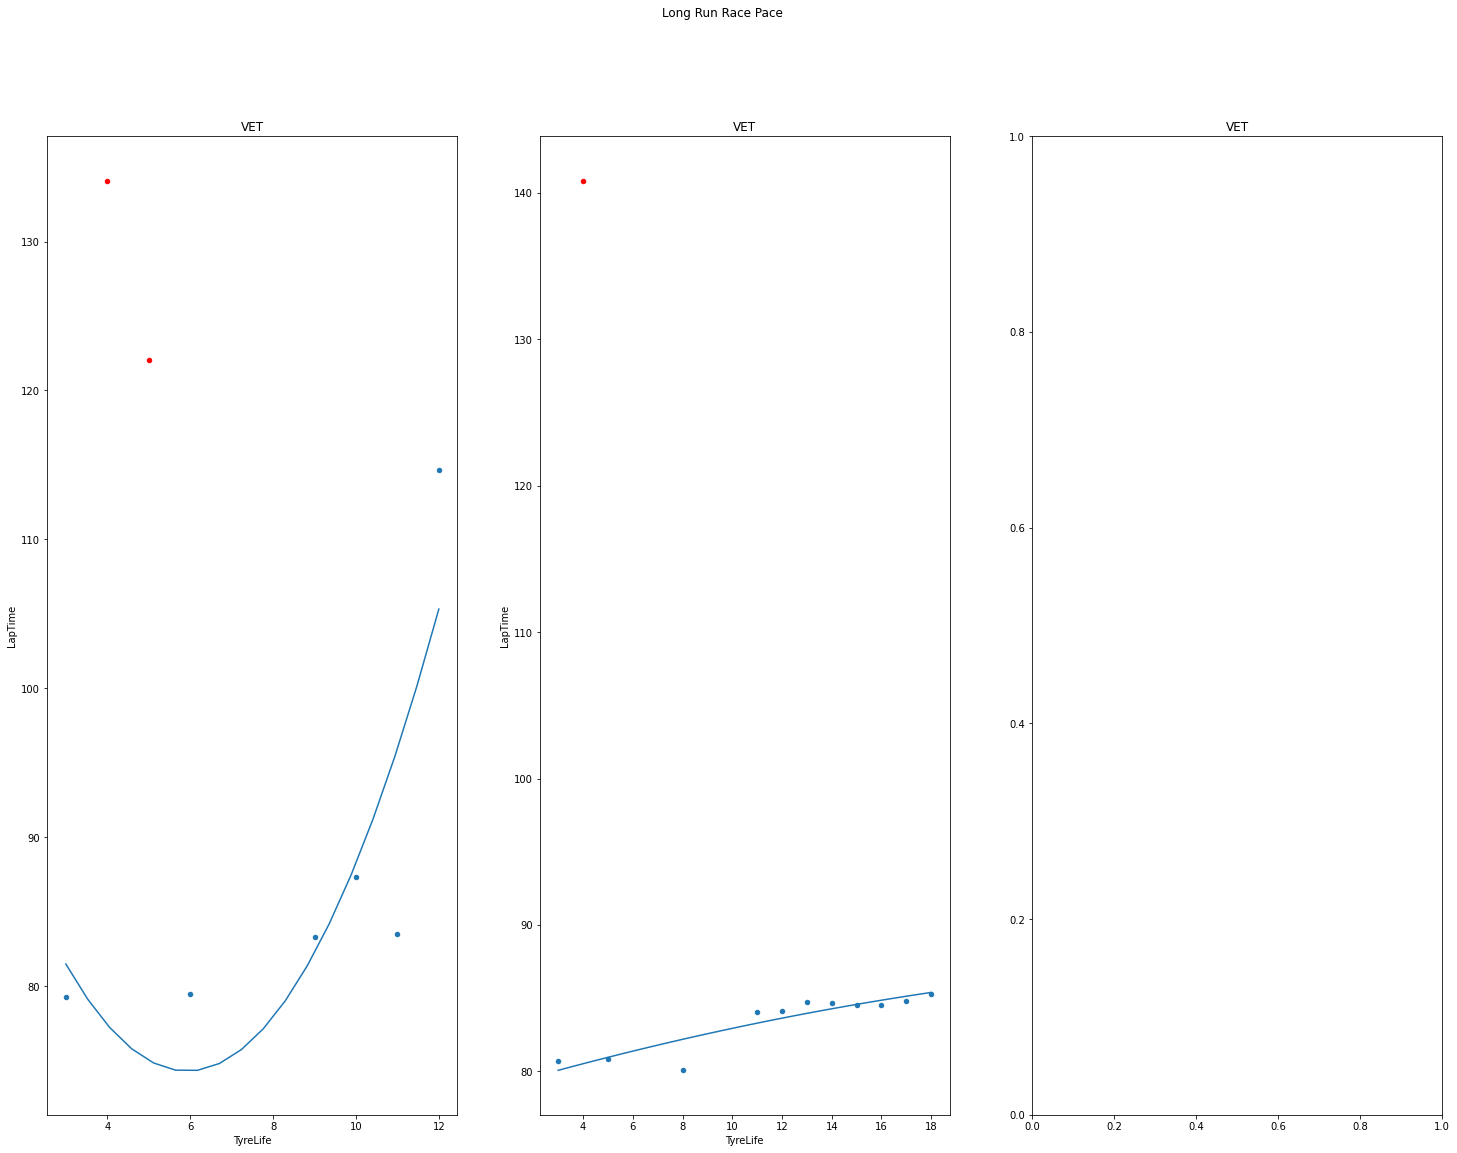

In [6]:
plot_dry_tyre_models_all_drivers(FP2.laps, ['VET'])

#### Race

In [5]:
grand_prix = ff1.get_session(2022, 'Hungary', 'R')
grand_prix.load()

core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.2.9]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data


KeyboardInterrupt: 

In [ ]:
grand_prix.laps.head()

In [ ]:
grand_prix.laps.pick_fastest()

In [ ]:
grand_prix.laps.LapTime.describe()

In [ ]:
race_laps = grand_prix.laps

In [ ]:
laps = race_laps.pick_driver(DRIVER)
laps.head()

In [ ]:
calculate_race_lap_times(laps)
laps.head()

In [ ]:
convert_laptime_to_seconds(laps)
laps.head()

In [ ]:
# Plot the graph
laptime_bar_graph = plot_lap_time_bar_graph(laps)


In [ ]:
# Use the unstack function to separate the LapTime based on Compounds so we can plot by color later (by ignoring the NA values)
laptime_line_graph = plot_lap_time_line_graph(laps)